# Basic pipeline for exploratory analysis

* [Load modules](#load-modules)
* [Load data](#load-data)
* [Preprocess data](#preprocess-data)
* [Run `robustica`](#run-robustica)

## Load modules <a class="anchor" id="load-modules"></a>

In [1]:
from robustica import RobustICA, corrmats

import pandas as pd
import numpy as np
from sklearn.utils import parallel_backend

import matplotlib.pyplot as plt
import seaborn as sns

## Load data from [Sastry (2019)](https://doi.org/10.1038/s41467-019-13483-w) <a class="anchor" id="load-data"></a>

In [2]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-13483-w/MediaObjects/41467_2019_13483_MOESM4_ESM.xlsx"
data = pd.ExcelFile(url)
data.sheet_names

['README',
 'Metadata',
 'Expression Data',
 'S matrix',
 'A matrix',
 'Media Recipes',
 'Gene Information']

In [3]:
data.parse("README")

,Sheet Name,Description
0,Experimental Conditions,Experimental conditions for each sample in PRE...
1,Expression Data,Expression levels of genes (log2 Transcripts p...
2,S matrix,I-modulon gene coefficients. Each column is an...
3,A matrix,Condition-specific i-modulon activities. Each ...
4,Media Description,Recipes for base media and trace element mixtures
5,Gene Information,Mapping of b-numbers to gene names/annotations...
6,NaN,NaN
7,Metadata Columns,Description
8,Sample ID,Unique sample identifier for experiment (e.g. ...
9,Study,Short 1-2 word description of study where samp...


## Preprocess data <a class="anchor" id="preprocess-data"></a>
Following the article's methods, we compute the log2FCs with respect to controls

In [4]:
# get gene expression
X = data.parse("Expression Data").set_index("log-TPM")

# get controls
controls = [c for c in X.columns if "control" in c]
print(controls)

# compute log2FCs with respect to controls
X = X - X[controls].mean(1).values.reshape(-1, 1)

X

['control__wt_glc__1', 'control__wt_glc__2']


,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,-0.061772,0.061772,0.636527,0.819793,-0.003615,-0.289353,-1.092023,-0.777289,0.161343,0.145641,...,-0.797097,-0.791859,0.080114,0.102154,0.608180,0.657673,0.813105,0.854813,0.427986,0.484338
b0003,-0.053742,0.053742,0.954439,1.334385,0.307588,0.128414,-0.872563,-0.277893,0.428542,0.391761,...,-0.309105,-0.352535,-0.155074,-0.077145,0.447030,0.439881,0.554528,0.569030,0.154905,0.294799
b0004,-0.065095,0.065095,-0.202697,0.119195,-0.264995,-0.546017,-1.918349,-1.577736,-0.474815,-0.495312,...,-0.184898,-0.225615,0.019575,0.063986,0.483343,0.452754,0.524828,0.581878,0.293239,0.341040
b0005,0.028802,-0.028802,-0.865171,-0.951179,0.428769,0.123564,-1.660351,-1.531147,0.240353,-0.151132,...,-0.308221,-0.581714,0.018820,0.004040,-1.228763,-1.451750,-0.839203,-0.529349,-0.413336,-0.478682
b0006,0.009087,-0.009087,-0.131039,-0.124079,-0.144870,-0.090152,-0.219917,-0.046648,-0.044537,-0.089204,...,1.464603,1.415706,1.230831,1.165153,0.447447,0.458852,0.421417,0.408077,1.151066,1.198529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,-0.261325,0.261325,-1.425581,-2.734490,0.181893,0.514395,-1.943947,-1.992701,0.066037,-0.695325,...,-0.885297,-0.462485,-2.734490,-1.451148,-1.379069,-1.567420,-0.999610,-1.726577,-2.734490,-1.189069
b4693,-0.278909,0.278909,1.361362,1.020310,0.608108,0.988541,2.558416,2.142724,3.120867,3.104887,...,-0.374963,0.856574,-1.147824,-0.814089,2.054471,1.853620,1.957717,1.943582,2.233115,2.023755
b4696_1,0.050526,-0.050526,1.166436,1.043373,-0.531441,-0.581626,0.914055,0.731165,-0.127269,-0.164046,...,0.261604,0.278426,0.201089,-0.017780,0.138178,0.122287,0.504402,0.425213,0.629383,0.805945


## Run `robustica` <a class="anchor" id="run-robustica"></a>

### Using our version of the *Icasso* algorithm
By default, `robustica` performs robust ICA by 
1. running [*FastICA*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) multiple times (`robust_runs`=100)
2. inferring and correcting the signs of components across runs (`robust_infer_signs=True`)
3. compressing the feature space (rows) (`robust_dimreduce=True`)
4. using sign-corrected and compressed components to obtain clusters of independent components (`robust_method="AgglomerativeClustering"` and `robust_kws={"linkage": "average"}`)
5. uses the clustering labels to compute robust independent components

In [5]:
%%time

rica = RobustICA(n_components=100, robust_runs=8)

with parallel_backend("loky", n_jobs=4):
    S, A = rica.fit_transform(X.values)

print(S.shape, A.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

Running FastICA multiple times...


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Inferring sign of components...
Reducing dimensions...
Clustering...
Computing centroids...
(3923, 100) (278, 100)
CPU times: user 3.71 s, sys: 312 ms, total: 4.02 s
Wall time: 7.6 s


### Using the classical *Icasso* algorithm

In [6]:
%%time

rica = RobustICA(
    n_components=100,
    robust_runs=8,
    robust_infer_signs=False,
    robust_dimreduce=False,
    robust_kws={"affinity": "precomputed", "linkage": "average"},
)

with parallel_backend("loky", n_jobs=4):
    S_classic, A_classic = rica.fit_transform(X.values)

print(S_classic.shape, A_classic.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

Running FastICA multiple times...


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Precomputing distance matrix...
Clustering...
Computing centroids...
(3923, 100) (278, 100)
CPU times: user 2.38 s, sys: 132 ms, total: 2.51 s
Wall time: 7.51 s


### Correspondence between the two approaches

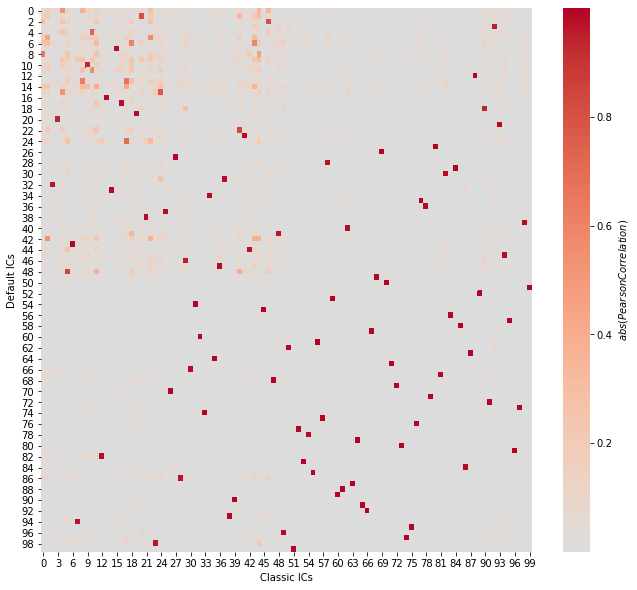

In [7]:
plt.figure(figsize=(11, 10))
sns.heatmap(
    np.abs(corrmats(S.T, S_classic.T)),
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": r"$abs(Pearson Correlation)$"},
)
plt.xlabel("Classic ICs")
plt.ylabel("Default ICs")

plt.show()